<a name="0"></a>
# Introduction

### About Us

Welcome to [C241-PS174]'s notebook!

This notebook contains the model used in our application, PawPal.

Our Machine Learning Team Members:

*   M281D4KX1467 - Alifya Meirza
*   M118D4KX2097 - Bintang Silalahi
*   M012D4KX2732 - Putri Nursyifa

Our Mobile Development Team Members:


*   A118D4KX4196 - Adinda Shafira Sholihin
*   A253D4KY4157 - Lalu Abdul Gofururrohiem



Our Cloud Computing Team Members:


*   C296D4KY0509 - Muhammad Abdul Hafizh Fathuddin
*   C296D4KY0027 - Muhammad Fawwas Shafiq Hudzaifa



### About PawPal

PawPal is an application developed by [C241-PS174] Capstone team as the Capstone Project for Bangkit 2024 Batch 2 Final Assignment.
<br>Find out more: https://github.com/lalugofur/Project-Capstone-Bangkit-Academy-2024

### Model Overview

We strive to achieve >70% accuracy in both training and validation

Our model consist of several transfer learning models, which we tune using flatten, dense, and dropout layers
<br>The model is trained in seperate ipynb. This is the inception_resnet_v2 transfer learning model.
<br>We achieved 73% in accuracy and 74% in validation accuracy

Other available models:
- ResNet v50
- InceptionV3

<a name="1"></a>
# Import Library

### Default library import

In [2]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import zipfile
import shutil
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont, ImageFile
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.backend as K

# from object_detection.utils import label_map_util
# from object_detection.utils import config_util
# from object_detection.utils import visualization_utils as viz_utils
# # from object_detection.utils import colab_utils
# from object_detection.builders import model_builder

%matplotlib inline

2024-06-10 23:50:03.173455: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 23:50:03.263415: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 23:50:04.095218: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-06-10 23:50:04.095318: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-06-10 23:50:04.098171: I tensorflow/c/logging.cc:34] Successfully open

# Preprocessing the Data

### Load the dataset

This dataset is a merged dataset and already cleaned prior.
<br>List of dataset used:
- CatBreedsRefined-7k, available at: https://www.kaggle.com/datasets/doctrinek/catbreedsrefined-7k
- Animal Breed - Cats and Dogs, (dropped the dog images and class) available at: https://www.kaggle.com/datasets/imsparsh/animal-breed-cats-and-dogs
- Cat Breed, available at: https://www.kaggle.com/datasets/solothok/cat-breed

In [3]:
# Load the dataset
NEW_DATA_DIR = './corrected_dataset'
cats_7k_data_dir = './corrected_dataset'
breed_names = os.listdir(cats_7k_data_dir)
print(breed_names)

['birman', 'mainecoon', 'norwegianforest', 'americancurl', 'exoticshorthair', 'sphynx', 'americanbobtail', 'egyptianmau', 'manx', 'scottishfold', 'ragdoll', 'americanshorthair', 'turkishangora', 'bengal', 'britishshorthair', 'abyssinian', 'siamese', 'russianblue', 'persian', 'bombay']


Removing Corrupted Images

In [3]:
# Get all breed names
breed_names = os.listdir(cats_7k_data_dir)
print(breed_names)

['Ragdoll', 'Maine Coon', 'CatBreedsRefined-v2', 'Bengal', 'Exotic Shorthair', 'British Shorthair', 'American Shorthair', 'Manx', 'Abyssinian', 'American Curl', 'Bombay', 'Sphynx', 'Egyptian Mau', 'Persian', 'Turkish Angora', 'Norwegian Forest', 'Siamese', 'Russian Blue', 'American Bobtail', 'Birman', 'Scottish Fold']


### Augmenting the data



In [4]:
# Augmenting training data
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_dataset = train_datagen.flow_from_directory(
    cats_7k_data_dir,
    subset="training",
    batch_size=128,
    target_size=(224,224),
    shuffle=True,
    class_mode='categorical'
)

Found 7227 images belonging to 20 classes.


In [5]:
# Augmenting validation data
validation_datagen = ImageDataGenerator(rescale = 1.0/255,
                                        validation_split=0.2)

validation_generator = validation_datagen.flow_from_directory(
    cats_7k_data_dir,
    target_size=(224,224),
    batch_size=128,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

Found 1799 images belonging to 20 classes.


In [6]:
num_classes = len(breed_names)
print(num_classes)

20


# Defining The Model

### Transfer Learning with InceptionV3

In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Initialize the base model.
pre_trained_model = InceptionV3(input_shape = (224, 224, 3),
                                include_top = False,
                                weights = 'imagenet')

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

2024-06-10 13:03:55.028225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 13:03:55.028603: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6800)
2024-06-10 13:03:55.074344: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 1 (AMD Radeon(TM) Graphics)
2024-06-10 13:03:55.115245: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-10 13:03:55.115259: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform

Picking the last layer to transfer to the new model

In [8]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [9]:
# Flatten the output layer
x = layers.MaxPooling2D(2,2)(pre_trained_model.output)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(num_classes, activation='softmax')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [10]:
STEP_SIZE_TRAIN=train_dataset.n// 128
STEP_SIZE_VALID=validation_generator.n// 128

##### Compile the model

In [12]:
optimum_learning_rate = 8.9125e-05
learning_rate_default = 0.001

In [13]:
tf.keras.backend.clear_session()
model.compile(optimizer=RMSprop(learning_rate=learning_rate_default),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

##### Train the model

In [14]:
history = model.fit(train_dataset,
                    steps_per_epoch=STEP_SIZE_TRAIN, validation_data=validation_generator, validation_steps=STEP_SIZE_VALID, epochs=100)

Epoch 1/100


2024-06-10 13:04:32.933306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-10 13:04:33.317649: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-10 13:04:33.317679: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-10 13:04:33.317691: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 28889 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-10 13:04:33.317700: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

56/56 [==============================] - ETA: 0s - loss: 3.0271 - accuracy: 0.2219

2024-06-10 13:05:15.995520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-10 13:05:16.286945: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-10 13:05:16.286969: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-10 13:05:16.286980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 28889 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-10 13:05:16.286987: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

56/56 [==============================] - 48s 812ms/step - loss: 3.0271 - accuracy: 0.2219 - val_loss: 2.0334 - val_accuracy: 0.3756
Epoch 2/100
56/56 [==============================] - 47s 847ms/step - loss: 2.0174 - accuracy: 0.4112 - val_loss: 1.5442 - val_accuracy: 0.5290
Epoch 3/100
56/56 [==============================] - 45s 810ms/step - loss: 1.7322 - accuracy: 0.4723 - val_loss: 1.4325 - val_accuracy: 0.5407
Epoch 4/100
56/56 [==============================] - 46s 819ms/step - loss: 1.5734 - accuracy: 0.5343 - val_loss: 1.2418 - val_accuracy: 0.6155
Epoch 5/100
56/56 [==============================] - 46s 818ms/step - loss: 1.4976 - accuracy: 0.5457 - val_loss: 1.3199 - val_accuracy: 0.5910
Epoch 6/100
56/56 [==============================] - 45s 801ms/step - loss: 1.4640 - accuracy: 0.5613 - val_loss: 1.1935 - val_accuracy: 0.6256
Epoch 7/100
56/56 [==============================] - 46s 814ms/step - loss: 1.3905 - accuracy: 0.5736 - val_loss: 1.2129 - val_accuracy: 0.6222
Epoc

Evaluation

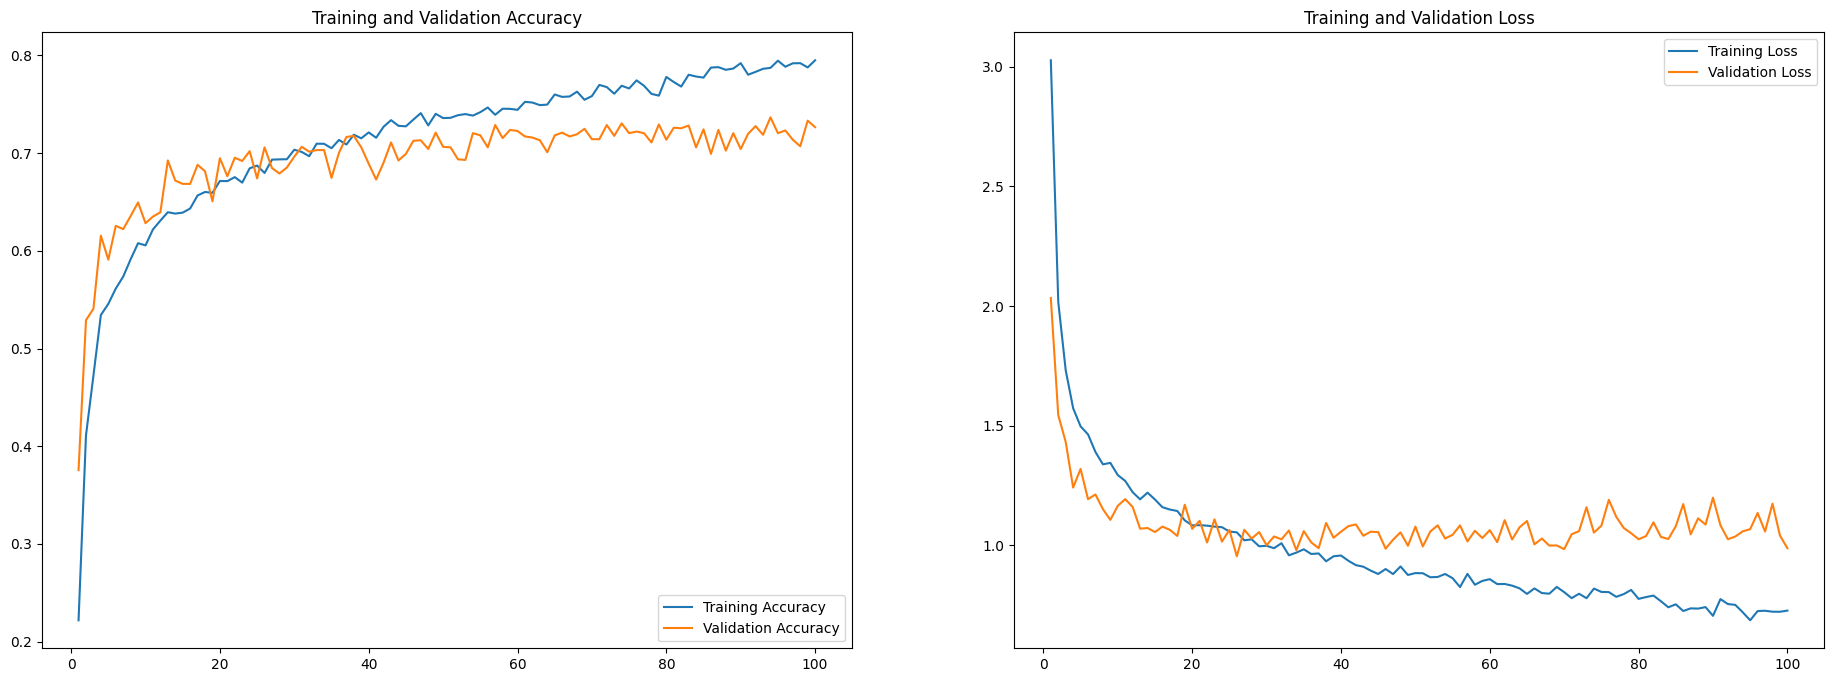

In [15]:
# first_model_uwauwu.h5
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

metrics = history.history['accuracy']
epochs_range = range(1, len(metrics) + 1)

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Save the model

In [16]:
model.save('model_72_2024_10_06.h5')